In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def compute_mmse(B, H, x, snr_db):
    n = B.shape[0]
    BH = B * H
    signal = BH @ x
    P_signal = np.sum(x**2) / n
    snr_linear = 10 ** (snr_db / 10)
    P_noise = P_signal / snr_linear
    z = np.random.normal(0, np.sqrt(P_noise), size=(n, 1))
    y = signal + z
    target = np.sum(x)
    estimate = np.sum(y)
    mmse = (estimate - target)**2
    return mmse


In [45]:
def norm(arr):
    return np.sum(arr * arr, axis=0)

In [46]:
# Dimensions
no_of_sources=5
no_of_slots=4
P_total = 2.5
max_iters = 100
snr=50  #from o to snr

In [47]:
mse = []
snrs = np.arange(0, snr+1)
for snr_db in snrs: 
    rnd_seed = 3
    np.random.seed(rnd_seed)
    
    lambda_reg = 1.0
    eta = 0.01
    eta_lambda = 0.1
    tol = 1e-6
    iterations = 100  # how many times to average

    # fixed H, x
    H = np.random.randn(no_of_slots, no_of_sources)
    x = np.random.uniform(-1, 1, size=(no_of_sources, 1))  
    B = np.random.randn(no_of_slots, no_of_sources)

    # optimize B
    for iter in range(max_iters):
        BH = B * H
        y = BH @ x + np.random.randn(no_of_slots, 1) - np.sum(x)
        grad = 2 * (y @ x.T) * H + 2 * lambda_reg * B

        B_new = B - eta * grad
        colwise_norms = norm(B_new)
        B_new1 = B_new.copy()

        if any(colwise_norms > P_total):      
            for i in range(B_new.shape[1]):  
                if colwise_norms[i] > P_total:
                    scaling_factor = np.sqrt(P_total / colwise_norms[i])
                    B_new1[:, i] *= scaling_factor
            total_col_sum = np.sum(colwise_norms)
            lambda_reg += eta_lambda * (total_col_sum - P_total)
            lambda_reg = max(0, lambda_reg)

        if np.linalg.norm(B_new1 - B, ord='fro') < tol:
            break

        B = B_new1

    # Now evaluate average MMSE across many realizations
    error = []
    for _ in range(iterations):
        err = compute_mmse(B, H, x, snr_db)
        error.append(err)
    mse.append(np.mean(error))

print("Final MSE values:", mse)


Final MSE values: [0.6875425480190109, 0.5462550487929111, 0.4340167995797971, 0.34485423377141794, 0.274022265223311, 0.21775163685500232, 0.17304823116700954, 0.13753365572149623, 0.10931861462207236, 0.08690232295439389, 0.06909260798920634, 0.054942442557006574, 0.04369953104268268, 0.03476626351791657, 0.027667905643371342, 0.022027330533479016, 0.01754494713863737, 0.013982756414078026, 0.011151686347384327, 0.008901531512687723, 0.007112961506629252, 0.005691172784653582, 0.00456084592255197, 0.003662139837279116, 0.002947509714423404, 0.0023791792475101347, 0.001927132632050069, 0.0015675194300579383, 0.0012813874022552887, 0.0010536758658627166, 0.0008724160055600668, 0.0007280955824035202, 0.0006131542368921077, 0.0005215825339720043, 0.00044860341971298, 0.0003904191457155066, 0.00034401020156526465, 0.0003069755633652492, 0.00027740576490985306, 0.0002537820444777203, 0.00023489620749348331, 0.00021978694730225967, 0.00020768924168419655, 0.0001979941381125613, 0.0001902167

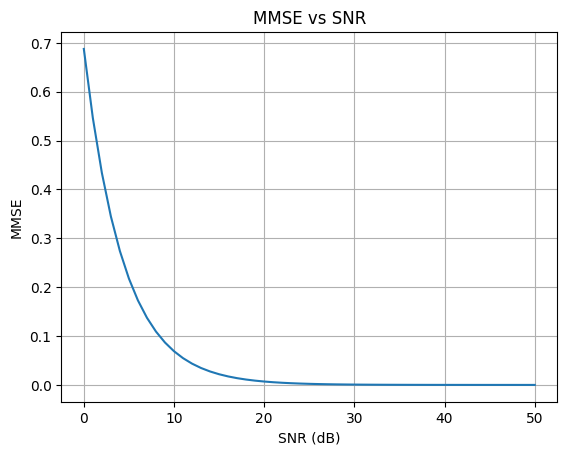

In [48]:
# Plot
plt.plot(snrs, mse)
plt.xlabel('SNR (dB)')
plt.ylabel('MMSE')
plt.title('MMSE vs SNR')
plt.grid(True)
plt.show()